Progetto Data Mining A.A. 2019/2020
=====

Asteroidi e comete: analisi del diametro, dell'orbita e della pericolosità
---

Francesco Pasceri matricola 204963

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow
import keras
from keras import Model, Input, Sequential
from keras.layers import Dense

print('Done')

path = 'drive/My Drive/DataMining/'

Done


Fase 5 Parte 1: Autoencoder
---

<b><u>
Per ottenere una buona fase di anomaly detection cerchiamo di capire se effettivamente i corpi PHA e quelli NON PHA sono effettivamente distinti nella rappresentazione attuale o hanno bisogno di un ulteriore pre-processamento.
</u></b>

## 1. Import data

In [2]:
with open(path+'data','rb') as f:
    data_ = pickle.load(f, encoding='latin1')
    
data_.head()

,neo,pha,H,diameter,albedo,e,a,q,i,om,w,ma,ad,n,per_y,moid,moid_jup,t_jup,class,condition_code,log(albedo),log(n),log(H),log(ad),log(e),log(om),log(i),log(q)
0,0,0,3.40,939.400,0.0900,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,4.608202,1.59478,2.09753,3.309,0,0,-2.407946,-1.542316,1.223775,1.091805,-2.576903,4.385838,2.360294,0.939493
1,0,0,4.20,545.000,0.1010,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,4.619880,1.23429,1.85093,3.042,0,0,-2.292635,-1.544847,1.435085,1.227225,-1.469797,5.153435,3.550563,0.758904
2,0,0,5.33,246.596,0.2140,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,4.358696,1.03429,2.18899,3.299,0,0,-1.541779,-1.486651,1.673351,1.210113,-1.358927,5.134924,2.564260,0.684462
3,0,0,3.00,525.400,0.4228,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,3.628837,1.13948,2.46988,3.535,0,0,-0.860856,-1.303390,1.098612,0.944266,-2.422253,4.642570,1.965961,0.766356
4,0,0,6.90,106.699,0.2740,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,4.129814,1.09575,1.95968,3.396,0,0,-1.294627,-1.432710,1.931521,1.120196,-1.655936,4.952802,1.680349,0.733626


## 2. Contiamo le anomalie e i dati normali

In [3]:
counts = data_['pha'].value_counts() * 1.
print('# No PHA->',counts[0], '\n# PHA->', counts[1])

# No PHA-> 138691.0 
# PHA-> 323.0


In [4]:
outlier_fraction = counts[1] / (counts[0] + counts[1]) 
print('outlier_fract', outlier_fraction)

outlier_fract 0.002323506984907995


## 3. Preprocessiamo i dati

In [5]:
data = data_.copy()

data['pha'] = data['pha'].replace({1: -1}) # pha -1
data['pha'] = data['pha'].replace({0: 1}) # no_pha 1

ds_anom = data[ data['pha']==-1 ]
ds_norm = data[ data['pha']==1 ].sample(500)

print('normal', ds_norm.shape)
print('anomalies', ds_anom.shape)
print()

normal (500, 28)
anomalies (323, 28)



In [6]:
df = ds_norm.append(ds_anom).sample(frac=1).reset_index(drop=True)
X = df.drop(['pha'], axis = 1).values
Y = df["pha"].values

print('data', X.shape)
print('labels', Y.shape)

data (823, 27)
labels (823,)


### 4. Visualizing data using TSNE 


Riferimento a TSNE [link](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html])

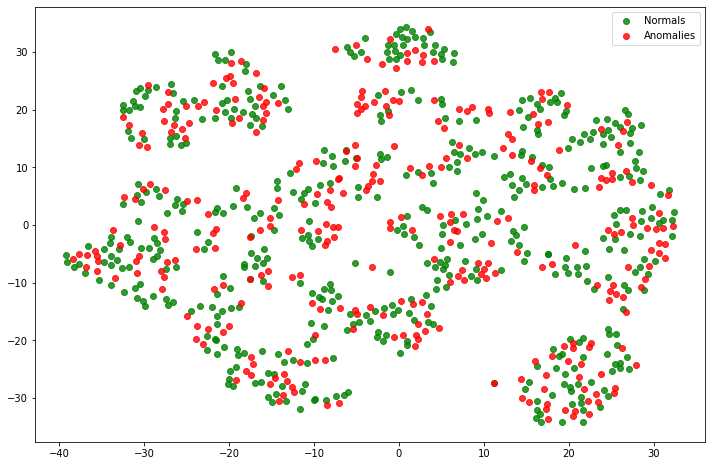

In [7]:
from sklearn.manifold import TSNE

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Normals')
    plt.scatter(X_t[np.where(y1 == -1), 0], X_t[np.where(y1 == -1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Anomalies')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

<b><u>
Come possiamo vedere, usando la TSNE per visualizzare dati ad elevata dimensionalità, i corpi pericolosi sono difficilmente distinguibili da quelli non pericolosi. Per questo motivo abbiamo bisogno di sfruttare qualche tool particolare per migliorare questa distinzione: useremo l'Autoencoder come feature extractor.
</u></b>

## 5. Costruzione Autoencoder con keras

In [8]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(20, activation='relu')(input_layer)
encoded = Dense(10, activation='relu')(encoded)

## decoding part
decoded = Dense(20, activation='relu')(encoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                560       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 27)                567       
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________


##### 1. Normalizziamo i dati con lo StandardScaler

In [9]:
x = data.drop(["pha"], axis=1)
y = data["pha"].values

x_scale = StandardScaler().fit_transform(x.values)
x_norm, x_anom = x_scale[y == 1], x_scale[y == -1]

print('normal', x_norm.shape)
print('anomalies', x_anom.shape)
print()

normal (138691, 27)
anomalies (323, 27)



##### 2. Addestriamo la rete neurale imponendo un limite di early stoppage

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = autoencoder.fit(x_norm[0:5000], x_norm[0:5000], 
                          epochs = 500, batch_size=32, shuffle = True, validation_split = 0.20,
                          callbacks=[callback])

Epoch 1/500
125/125 [==============================] - 0s 3ms/step - loss: 2.2636 - val_loss: 1.1560
Epoch 2/500
125/125 [==============================] - 0s 2ms/step - loss: 1.8181 - val_loss: 1.0202
Epoch 3/500
125/125 [==============================] - 0s 2ms/step - loss: 1.6319 - val_loss: 0.9351
Epoch 4/500
125/125 [==============================] - 0s 2ms/step - loss: 1.5206 - val_loss: 0.8538
Epoch 5/500
125/125 [==============================] - 0s 2ms/step - loss: 1.4365 - val_loss: 0.8019
Epoch 6/500
125/125 [==============================] - 0s 2ms/step - loss: 1.3895 - val_loss: 0.7797
Epoch 7/500
125/125 [==============================] - 0s 2ms/step - loss: 1.3582 - val_loss: 0.7665
Epoch 8/500
125/125 [==============================] - 0s 2ms/step - loss: 1.3346 - val_loss: 0.7572
Epoch 9/500
125/125 [==============================] - 0s 2ms/step - loss: 1.3169 - val_loss: 0.7523
Epoch 10/500
125/125 [==============================] - 0s 2ms/step - loss: 1.3029 - val_lo

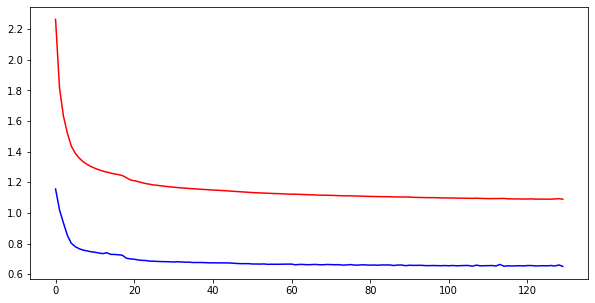

In [11]:
mse_train = history.history['loss']
mse_test = history.history['val_loss']

plt.figure(figsize=(10,5))
epochs = np.arange( len(mse_test) )
plt.plot( epochs, mse_train, color='red')
plt.plot( epochs, mse_test, color='blue' )
plt.show()

##### 3. Costruiamo una nuova rete neurale formata dal bottleneck dell'Autoencoder per ottenere la rappresentazione ristretta dei dati

In [12]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

norm_hid_rep = hidden_representation.predict(x_norm[:3000])
anom_hid_rep = hidden_representation.predict(x_anom)

In [13]:
rep_x = np.append(norm_hid_rep, anom_hid_rep, axis = 0)
y_n = np.ones(norm_hid_rep.shape[0])
y_f = -1 * np.ones(anom_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

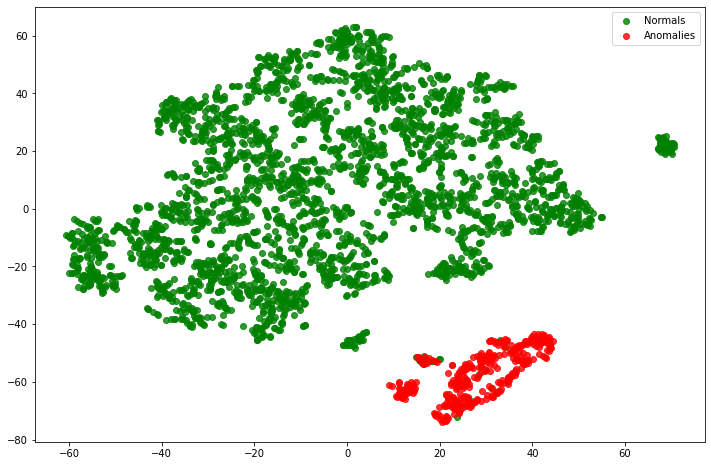

In [14]:
tsne_plot(rep_x, rep_y, "latent_representationTot.png")

In [17]:
with open('lat_x','wb') as f:
    pickle.dump(rep_x,f)
with open('lat_y','wb') as f:
    pickle.dump(rep_y,f)